# 0_proteinanalysis

Notebook for analyzing protein simulations

In [1]:
#############################Import Block#############################
# import plotly.express as px #plotting
import matplotlib.pyplot as plt #plotting
from pathlib import Path #paths
import glob #glob files
import os #system commands in case we need it
import numpy as np #handling numbers if needed
import pandas as pd #handling data in dataframes
import pytraj as pt #cpptraj, but python
from pymol import cmd,stored #pymol commands and stuffs
import scipy.stats as stats #for stats.entropy
#############################Import Block#############################

## 0. Define paths and input directory

In [2]:
# set current directory as absolute path
## in this notebook current path == work path
current_dir = Path().absolute()

In [3]:
# set directory where we saved example trajectories to load
data_dir = Path('/Users/stevenramsey/from_yeonji')
trajectories = glob.glob(str(data_dir / '*.nc'))
print(trajectories)
topologies = glob.glob(str(data_dir / '*.prmtop'))
print(topologies)
pdbfiles = glob.glob(str(data_dir / '*.pdb'))
print(pdbfiles)
sdffiles = glob.glob(str(data_dir / '*.sdf'))
print(sdffiles)

['/Users/stevenramsey/from_yeonji/nos1_bbr_20ns_1000frames.nc', '/Users/stevenramsey/from_yeonji/nos1_3dr_100ns_1000frames.nc']
['/Users/stevenramsey/from_yeonji/nos1.prmtop']
['/Users/stevenramsey/from_yeonji/nos1_bbr_first.pdb', '/Users/stevenramsey/from_yeonji/nos1_bbr_average.pdb', '/Users/stevenramsey/from_yeonji/aligned_ligand.pdb', '/Users/stevenramsey/from_yeonji/nos1_ahr_average.pdb']
[]


In [4]:
# set output directory and create it
out_dir = current_dir / 'Output'
out_dir.mkdir(parents=True, exist_ok=True)

## 1. Load trajectories

In [5]:
###trajectories in this example are restrained
## either bb restraints or 3 sites to prevent rotation/translation
## as such these trajectories do not need to be aligned, though I will 
## write the aligning line and then comment it out so as to be complete

traj1 = pt.load(trajectories[0], topologies[0]) #bbr, can add stride to skip frames
#traj1 = pt.align(traj1, ref_mask='@CA') set traj1 to aligned by CA, default to first frame of traj
traj2 = pt.load(trajectories[1], topologies[0]) #3dr
#traj2 = pt.align(traj2, ref_mask='@CA')
ref1 = pt.load(pdbfiles[0]) #first frame bbr reference

In [6]:
traj1

pytraj.Trajectory, 1000 frames: 
Size: 1.689859 (GB)
<Topology: 75603 atoms, 17633 residues, 17212 mols, PBC with box type = orthorhombic>
           

In [7]:
traj2

pytraj.Trajectory, 1000 frames: 
Size: 1.689859 (GB)
<Topology: 75603 atoms, 17633 residues, 17212 mols, PBC with box type = orthorhombic>
           

In [8]:
ref1

pytraj.Trajectory, 1 frames: 
Size: 0.001305 (GB)
<Topology: 58392 atoms, 17633 residues, 17212 mols, PBC with box type = orthorhombic>
           

## 1.5 Make some dataframes for data storage

In [9]:
#for global metrics (ie all protein)
global_df = pd.DataFrame()
#for by residue metrics
byresid_df = pd.DataFrame()

## 2. Protein CA RMSD

In [10]:
traj1_ca_rmsd = pt.rmsd_nofit(traj1, mask='@CA')
traj1_name = []
traj1_frame = []
traj1_timestep = 20 # 20 ns at 1 ps saverate cut to 1000 frames, each frame is 20 ps
for k,rms in enumerate(traj1_ca_rmsd):
    traj1_name.append('traj1')
    traj1_frame.append(k*traj1_timestep)
traj2_ca_rmsd = pt.rmsd_nofit(traj2, mask='@CA')
traj2_name = []
traj2_frame = []
traj2_timestep = 100 #100 ns at 1 ps saverate cut to 1000 frames, each frame is 100 ps
for k,rms in enumerate(traj2_ca_rmsd):
    traj2_name.append('traj2')
    traj2_frame.append(k*traj2_timestep)

df1 = pd.DataFrame()
df1['system'] = traj1_name
df1['time'] = traj1_frame
df1['CA RMSD'] = traj1_ca_rmsd
df2 = pd.DataFrame()
df2['system'] = traj2_name
df2['CA RMSD'] = traj2_ca_rmsd
df2['time'] = traj2_frame

CA_df = pd.concat([df1, df2])
CA_df

,system,time,CA RMSD
0,traj1,0,0.000000
1,traj1,20,0.275680
2,traj1,40,0.275864
3,traj1,60,0.276273
4,traj1,80,0.282776
...,...,...,...
995,traj2,99500,125.127685
996,traj2,99600,127.108925
997,traj2,99700,129.560451
998,traj2,99800,130.444482


## 2.1 Save intermediate dataframe

In [11]:
CA_df.to_csv(out_dir / 'CA_df.csv', index=False)

## 2.2 Plot results and save

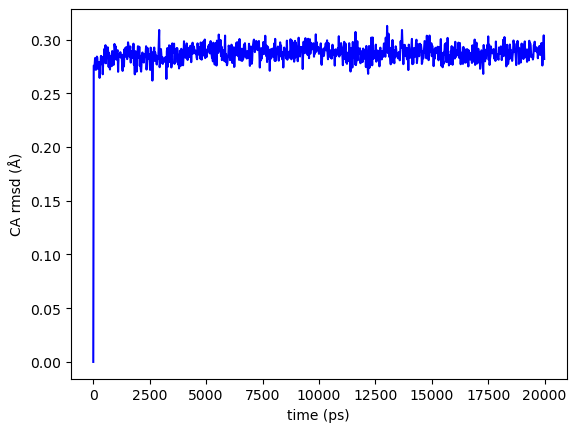

In [12]:
plt.plot(traj1_frame, traj1_ca_rmsd, 'b-')
plt.xlabel('time (ps)')
plt.ylabel('CA rmsd (Å)')
plt.savefig(str(out_dir / 'traj1_CA_rmsd.png'))
plt.show()

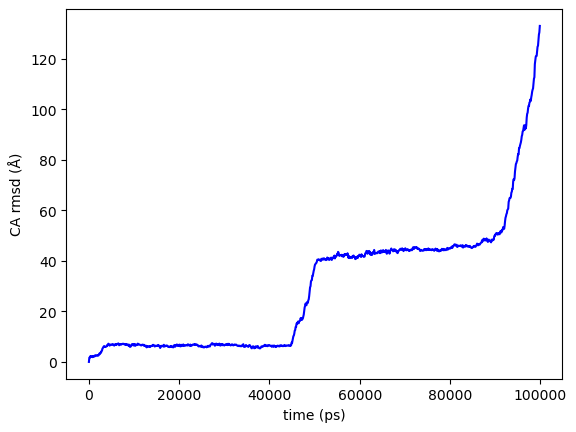

In [13]:
plt.plot(traj2_frame, traj2_ca_rmsd, 'b-')
plt.xlabel('time (ps)')
plt.ylabel('CA rmsd (Å)')
plt.savefig(str(out_dir / 'traj2_CA_rmsd.png'))
plt.show()

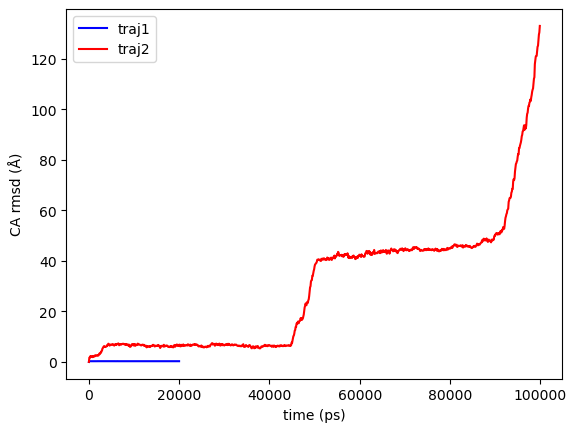

In [14]:
plt.plot(traj1_frame, traj1_ca_rmsd, 'b-', traj2_frame, traj2_ca_rmsd, 'r-')
plt.xlabel('time (ps)')
plt.ylabel('CA rmsd (Å)')
plt.legend(['traj1', 'traj2'])
plt.savefig(str(out_dir / 'all_CA_rmsd.png'))
plt.show()

## 3. Protein BB RMSD

In [15]:
traj1_bb_rmsd = pt.rmsd_nofit(traj1, mask='!:HOH,WAT&@CA,C,N,O')
traj1_name = []
traj1_frame = []
traj1_timestep = 20 # 20 ns at 1 ps saverate cut to 1000 frames, each frame is 20 ps
for k,rms in enumerate(traj1_ca_rmsd):
    traj1_name.append('traj1')
    traj1_frame.append(k*traj1_timestep)
traj2_bb_rmsd = pt.rmsd_nofit(traj2, mask='!:HOH,WAT&@CA,C,N,O')
traj2_name = []
traj2_frame = []
traj2_timestep = 100 #100 ns at 1 ps saverate cut to 1000 frames, each frame is 100 ps
for k,rms in enumerate(traj2_ca_rmsd):
    traj2_name.append('traj2')
    traj2_frame.append(k*traj2_timestep)

df1['BB RMSD'] = traj1_bb_rmsd
df2['BB RMSD'] = traj2_bb_rmsd

BB_df = pd.concat([df1, df2])
BB_df

,system,time,CA RMSD,BB RMSD
0,traj1,0,0.000000,0.000000
1,traj1,20,0.275680,0.314739
2,traj1,40,0.275864,0.320713
3,traj1,60,0.276273,0.313164
4,traj1,80,0.282776,0.319985
...,...,...,...,...
995,traj2,99500,125.127685,125.400933
996,traj2,99600,127.108925,127.377322
997,traj2,99700,129.560451,129.736078
998,traj2,99800,130.444482,130.625754


## 3.1 Save dataframe

In [16]:
BB_df.to_csv(out_dir / 'BB_df.csv', index=False)

## 3.2 Plot results and save

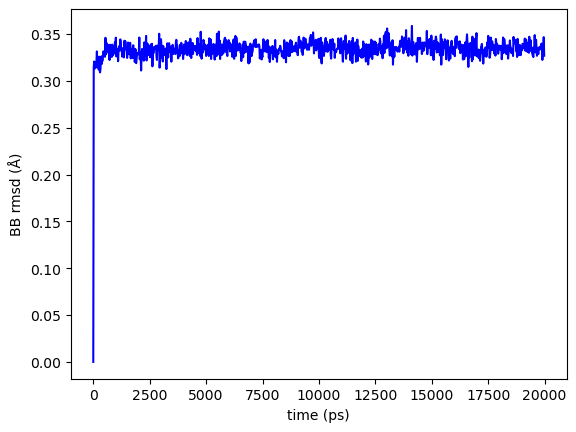

In [17]:
plt.plot(traj1_frame, traj1_bb_rmsd, 'b-')
plt.xlabel('time (ps)')
plt.ylabel('BB rmsd (Å)')
plt.savefig(str(out_dir / 'traj1_BB_rmsd.png'))
plt.show()

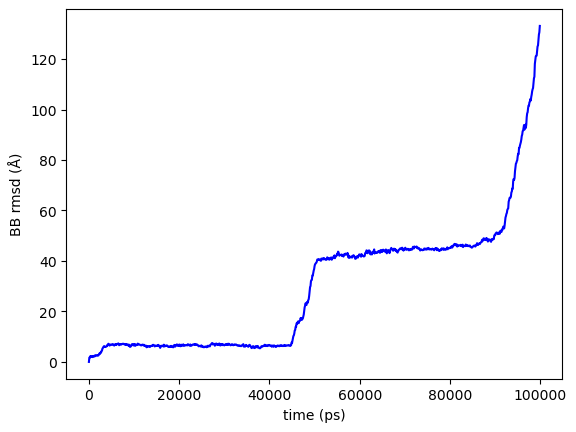

In [18]:
plt.plot(traj2_frame, traj2_bb_rmsd, 'b-')
plt.xlabel('time (ps)')
plt.ylabel('BB rmsd (Å)')
plt.savefig(str(out_dir / 'traj2_BB_rmsd.png'))
plt.show()

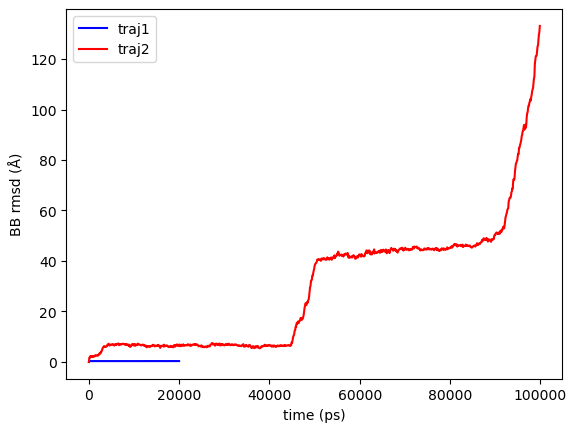

In [19]:
plt.plot(traj1_frame, traj1_bb_rmsd, 'b-', traj2_frame, traj2_bb_rmsd, 'r-')
plt.xlabel('time (ps)')
plt.ylabel('BB rmsd (Å)')
plt.legend(['traj1', 'traj2'])
plt.savefig(str(out_dir / 'all_BB_rmsd.png'))
plt.show()

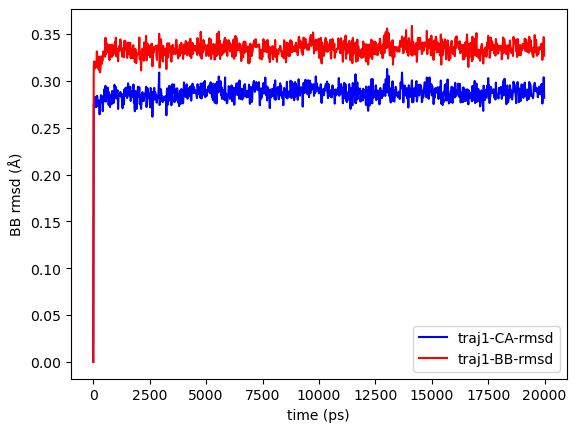

In [20]:
plt.plot(traj1_frame, traj1_ca_rmsd, 'b-', traj1_frame, traj1_bb_rmsd, 'r-')
plt.xlabel('time (ps)')
plt.ylabel('BB rmsd (Å)')
plt.legend(['traj1-CA-rmsd', 'traj1-BB-rmsd'])
plt.savefig(str(out_dir / 'traj1_CABB_rmsd.png'))
plt.show()

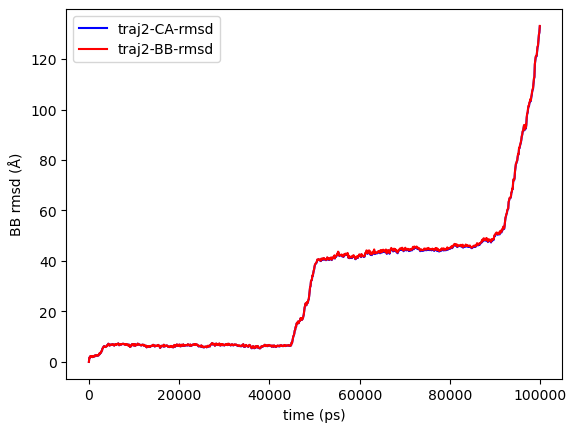

In [21]:
plt.plot(traj2_frame, traj2_ca_rmsd, 'b-', traj2_frame, traj2_bb_rmsd, 'r-')
plt.xlabel('time (ps)')
plt.ylabel('BB rmsd (Å)')
plt.legend(['traj2-CA-rmsd', 'traj2-BB-rmsd'])
plt.savefig(str(out_dir / 'traj2_CABB_rmsd.png'))
plt.show()

## 4. Protein all residue, by residue, RMSD's

## 4.1 use pymol to determine the residue numbers of our protein -- this will include all domains/peptides

In [22]:
cmd.reinitialize()
stored.list = []
resnames = []
resids = []
cmd.load(pdbfiles[0])
cmd.select('protein-residues', 'polymer.protein and name CA')
cmd.iterate('protein-residues', 'stored.list.append((resi, resn))')
for k,tup in enumerate(stored.list):
    resnames.append(tup[1])
    resids.append(tup[0])
    
# for k,res in enumerate(resids):
#     print(resnames[k], res)

#firstres = resids[0]
#lastres = resids[-1]

## 4.2 Loop through each residue to get its rmsds

In [23]:
#traj1
byres_df1 = pd.DataFrame()
time = []
resid = []
resname = []
system = []
bb_rmsd = [] #backbone
ca_rmsd = [] #alpha carbon
sc_rmsd = [] #sidechain
ha_rmsd = [] #heavy atoms
##################Additions 07/13##############################
resid_stats = [] #need additional lists here for the stats df
resname_stats = []
system_stats = []
bb_rmsd_avg = [] #storage for average bb rmsd
ca_rmsd_avg = [] #storage for average ca rmsd
sc_rmsd_avg = [] #storage for average sc rmsd
ha_rmsd_avg = [] #storage for average ha rmsd
ca_rmsd_std = []
ca_rmsd_std1 = []
ca_rmsd_std2 = []
bb_rmsd_std = [] #storage for stdev 
bb_rmsd_std1 = [] #storage for first half stdev
bb_rmsd_std2 = [] #storage for second half stdev
sc_rmsd_std = []
sc_rmsd_std1 = []
sc_rmsd_std2 = []
ha_rmsd_std = []
ha_rmsd_std1 = []
ha_rmsd_std2 = []
##################Additions 07/13##############################
for k,res in enumerate(resids):
    ca = pt.rmsd_nofit(traj1, mask=f':{res}&@CA')
    bb = pt.rmsd_nofit(traj1, mask=f':{res}&@CA,C,N,O&!:HOH,WAT')
    sc = pt.rmsd_nofit(traj1, mask=f':{res}&!@CA,C,N,O&!:HOH,WAT')
    ha = pt.rmsd_nofit(traj1, mask=f':{res}&!:HOH,WAT&!@H=')
    ca_avg = np.mean(ca)
    bb_avg = np.mean(bb)
    sc_avg = np.mean(sc)
    ha_avg = np.mean(ha)
    ca_std = np.std(ca)
    bb_std = np.std(bb)
    sc_std = np.std(sc)
    ha_std = np.std(ha)
    ca_std1 = np.std(ca[:int(len(ca)/2)])
    bb_std1 = np.std(bb[:int(len(ca)/2)])
    sc_std1 = np.std(sc[:int(len(ca)/2)])
    ha_std1 = np.std(ha[:int(len(ca)/2)])
    ca_std2 = np.std(ca[int(len(ca)/2):])
    bb_std2 = np.std(bb[int(len(ca)/2):])
    sc_std2 = np.std(sc[int(len(ca)/2):])
    ha_std2 = np.std(ha[int(len(ca)/2):])
    bb_rmsd_avg.append(bb_avg) 
    ca_rmsd_avg.append(ca_avg)
    sc_rmsd_avg.append(sc_avg)
    ha_rmsd_avg.append(ha_avg)
    ca_rmsd_std.append(ca_std)
    ca_rmsd_std1.append(ca_std1)
    ca_rmsd_std2.append(ca_std2)
    bb_rmsd_std.append(bb_std)
    bb_rmsd_std1.append(bb_std1)
    bb_rmsd_std2.append(bb_std2)
    sc_rmsd_std.append(sc_std)
    sc_rmsd_std1.append(sc_std1)
    sc_rmsd_std2.append(sc_std2)
    ha_rmsd_std.append(ha_std)
    ha_rmsd_std1.append(ha_std1)
    ha_rmsd_std2.append(ha_std2)
    for j,rms in enumerate(ca):
        time.append(j*traj1_timestep)
        resid.append(res)
        resname.append(resnames[k])
        system.append('traj1')
        ca_rmsd.append(rms)
        bb_rmsd.append(bb[j])
        sc_rmsd.append(sc[j])
        ha_rmsd.append(ha[j])
byres_df1['time'] = time
byres_df1['resid'] = resid
byres_df1['resname'] = resname
byres_df1['CA RMSD'] = ca_rmsd
byres_df1['BB RMSD'] = bb_rmsd
byres_df1['SC RMSD'] = sc_rmsd
byres_df1['HA RMSD'] = ha_rmsd
byres_df1.to_csv(str(out_dir / 'traj1_byres.csv'), index=False)
byres_df1

,time,resid,resname,CA RMSD,BB RMSD,SC RMSD,HA RMSD
0,0,2,GLY,0.000000,0.000000,0.000000,0.000000
1,20,2,GLY,0.140185,0.226612,0.074666,0.226612
2,40,2,GLY,0.344687,0.355538,0.360163,0.355538
3,60,2,GLY,0.608696,0.417490,0.685280,0.417490
4,80,2,GLY,0.148272,0.239948,0.255121,0.239948
...,...,...,...,...,...,...,...
419995,19900,421,TRP,0.411463,0.372900,1.032121,0.836720
419996,19920,421,TRP,0.279522,0.603498,0.929768,0.784465
419997,19940,421,TRP,0.227741,0.564478,1.133268,0.970448
419998,19960,421,TRP,0.328556,0.332413,1.720977,1.401418


In [24]:
byres_stats1 = pd.DataFrame()
byres_stats1['resid'] = resids
byres_stats1['resname'] = resnames
byres_stats1['mean CA rmsd'] = ca_rmsd_avg
byres_stats1['mean BB rmsd'] = bb_rmsd_avg
byres_stats1['mean SC rmsd'] = sc_rmsd_avg
byres_stats1['mean HA rmsd'] = ha_rmsd_avg
byres_stats1['std CA rmsd'] = ca_rmsd_std
byres_stats1['std BB rmsd'] = bb_rmsd_std
byres_stats1['std SC rmsd'] = sc_rmsd_std
byres_stats1['std HA rmsd'] = ha_rmsd_std
byres_stats1['std1 CA rmsd'] = ca_rmsd_std1
byres_stats1['std1 BB rmsd'] = bb_rmsd_std1
byres_stats1['std1 SC rmsd'] = sc_rmsd_std1
byres_stats1['std1 HA rmsd'] = ha_rmsd_std1
byres_stats1['std2 CA rmsd'] = ca_rmsd_std2
byres_stats1['std2 BB rmsd'] = bb_rmsd_std2
byres_stats1['std2 SC rmsd'] = sc_rmsd_std2
byres_stats1['std2 HA rmsd'] = ha_rmsd_std2
byres_stats1.to_csv(str(out_dir / 'traj1_byres_stats.csv'), index=False)
byres_stats1

,resid,resname,mean CA rmsd,mean BB rmsd,mean SC rmsd,mean HA rmsd,std CA rmsd,std BB rmsd,std SC rmsd,std HA rmsd,std1 CA rmsd,std1 BB rmsd,std1 SC rmsd,std1 HA rmsd,std2 CA rmsd,std2 BB rmsd,std2 SC rmsd,std2 HA rmsd
0,2,GLY,0.280125,0.308952,0.407037,0.308952,0.114602,0.102409,0.132449,0.102409,0.113832,0.102591,0.134866,0.102591,0.115249,0.102192,0.129804,0.102192
1,3,PRO,0.321400,0.366562,0.736804,0.462411,0.137016,0.117090,0.264433,0.124347,0.136812,0.116390,0.271331,0.127443,0.137157,0.117626,0.257145,0.120987
2,4,ARG,0.316971,0.351733,3.223402,2.543129,0.144212,0.129410,1.721772,1.398709,0.146531,0.127900,1.418546,1.117452,0.141669,0.130838,1.245136,1.044358
3,5,PHE,0.249304,0.264882,0.746635,0.534903,0.106667,0.079149,0.285338,0.209084,0.101411,0.077080,0.201950,0.148257,0.111632,0.081164,0.296149,0.221425
4,6,LEU,0.215837,0.328906,0.982680,0.405148,0.089298,0.135838,0.253531,0.116153,0.084423,0.130668,0.255736,0.112617,0.093795,0.140706,0.250832,0.119441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,417,ASN,0.276949,0.347425,1.052878,0.754858,0.109819,0.137790,0.743120,0.500045,0.109218,0.136907,0.566385,0.351867,0.110398,0.138564,0.849467,0.587296
416,418,THR,0.314529,0.348335,0.962366,0.469866,0.105471,0.102957,0.292077,0.127974,0.107236,0.109480,0.282253,0.121434,0.103672,0.095805,0.301352,0.134165
417,419,HIE,0.367421,0.382523,0.660782,0.525644,0.122675,0.101290,0.279287,0.216929,0.126979,0.107148,0.305138,0.235578,0.117908,0.095030,0.250184,0.195572
418,420,VAL,0.256387,0.278110,1.548037,0.686277,0.121240,0.091589,0.653749,0.385669,0.120348,0.093549,0.688810,0.407595,0.121935,0.089402,0.593879,0.351529


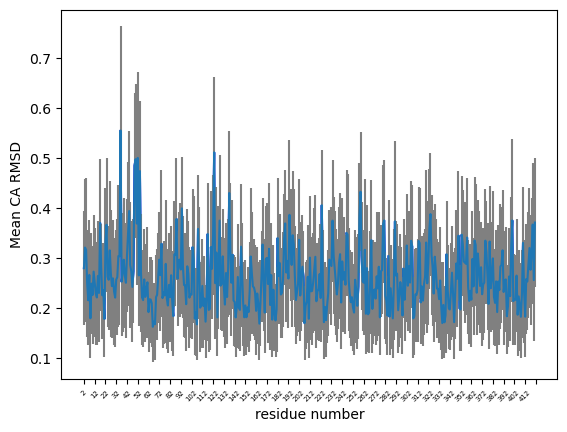

In [25]:
plt.plot(resids, ca_rmsd_avg, 'b-')
plt.errorbar(resids, ca_rmsd_avg, ca_rmsd_std, ecolor='gray')
plt.xlabel('residue number')
plt.xticks(rotation=45)
plt.xticks(np.arange(0, len(resids)+1, 10))
plt.xticks(fontsize=5)
plt.ylabel('Mean CA RMSD')
# plt.legend(['traj2-CA-rmsd', 'traj2-BB-rmsd'])
plt.savefig(str(out_dir / 'traj1_mean_ca_rmsd.png'))
plt.show()

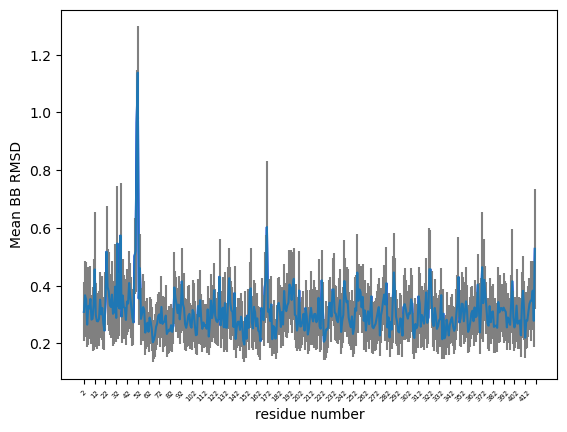

In [26]:
plt.plot(resids, bb_rmsd_avg, 'b-')
plt.errorbar(resids, bb_rmsd_avg, bb_rmsd_std, ecolor='gray')
plt.xlabel('residue number')
plt.xticks(rotation=45)
plt.xticks(np.arange(0, len(resids)+1, 10))
plt.xticks(fontsize=5)
plt.ylabel('Mean BB RMSD')
# plt.legend(['traj2-CA-rmsd', 'traj2-BB-rmsd'])
plt.savefig(str(out_dir / 'traj1_mean_bb_rmsd.png'))
plt.show()

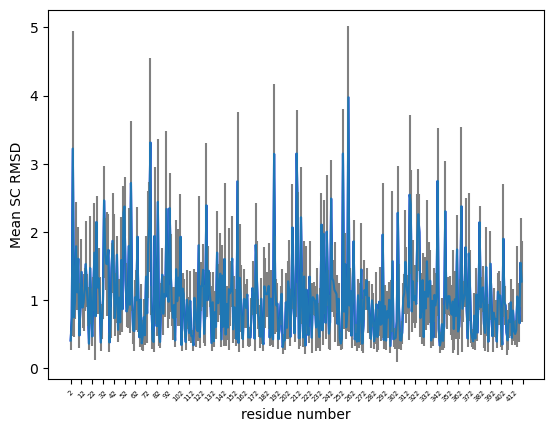

In [27]:
plt.plot(resids, sc_rmsd_avg, 'b-')
plt.errorbar(resids, sc_rmsd_avg, sc_rmsd_std, ecolor='gray')
plt.xlabel('residue number')
plt.xticks(rotation=45)
plt.xticks(np.arange(0, len(resids)+1, 10))
plt.xticks(fontsize=5)
plt.ylabel('Mean SC RMSD')
# plt.legend(['traj2-CA-rmsd', 'traj2-BB-rmsd'])
plt.savefig(str(out_dir / 'traj1_mean_sc_rmsd.png'))
plt.show()

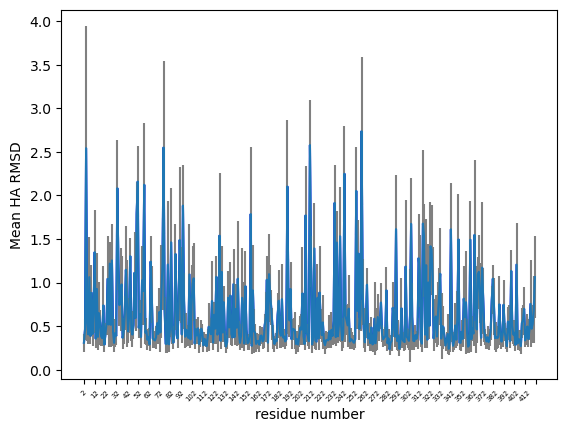

In [28]:
plt.plot(resids, ha_rmsd_avg, 'b-')
plt.errorbar(resids, ha_rmsd_avg, ha_rmsd_std, ecolor='gray')
plt.xlabel('residue number')
plt.xticks(rotation=45)
plt.xticks(np.arange(0, len(resids)+1, 10))
plt.xticks(fontsize=5)
plt.ylabel('Mean HA RMSD')
# plt.legend(['traj2-CA-rmsd', 'traj2-BB-rmsd'])
plt.savefig(str(out_dir / 'traj1_mean_ha_rmsd.png'))
plt.show()

In [29]:
#traj2
byres_df2 = pd.DataFrame()
time = []
resid = []
resname = []
system = []
bb_rmsd = [] #backbone
ca_rmsd = [] #alpha carbon
sc_rmsd = [] #sidechain
ha_rmsd = [] #heavy atoms
##################Additions 07/13##############################
resid_stats = [] #need additional lists here for the stats df
resname_stats = []
system_stats = []
bb_rmsd_avg = [] #storage for average bb rmsd
ca_rmsd_avg = [] #storage for average ca rmsd
sc_rmsd_avg = [] #storage for average sc rmsd
ha_rmsd_avg = [] #storage for average ha rmsd
ca_rmsd_std = []
ca_rmsd_std1 = []
ca_rmsd_std2 = []
bb_rmsd_std = [] #storage for stdev 
bb_rmsd_std1 = [] #storage for first half stdev
bb_rmsd_std2 = [] #storage for second half stdev
sc_rmsd_std = []
sc_rmsd_std1 = []
sc_rmsd_std2 = []
ha_rmsd_std = []
ha_rmsd_std1 = []
ha_rmsd_std2 = []
##################Additions 07/13##############################
for k,res in enumerate(resids):
    ca = pt.rmsd_nofit(traj2, mask=f':{res}&@CA')
    bb = pt.rmsd_nofit(traj2, mask=f':{res}&@CA,C,N,O&!:HOH,WAT')
    sc = pt.rmsd_nofit(traj2, mask=f':{res}&!@CA,C,N,O&!:HOH,WAT')
    ha = pt.rmsd_nofit(traj2, mask=f':{res}&!:HOH,WAT&!@H=')
    ca_avg = np.mean(ca)
    bb_avg = np.mean(bb)
    sc_avg = np.mean(sc)
    ha_avg = np.mean(ha)
    ca_std = np.std(ca)
    bb_std = np.std(bb)
    sc_std = np.std(sc)
    ha_std = np.std(ha)
    ca_std1 = np.std(ca[:int(len(ca)/2)])
    bb_std1 = np.std(bb[:int(len(ca)/2)])
    sc_std1 = np.std(sc[:int(len(ca)/2)])
    ha_std1 = np.std(ha[:int(len(ca)/2)])
    ca_std2 = np.std(ca[int(len(ca)/2):])
    bb_std2 = np.std(bb[int(len(ca)/2):])
    sc_std2 = np.std(sc[int(len(ca)/2):])
    ha_std2 = np.std(ha[int(len(ca)/2):])
    bb_rmsd_avg.append(bb_avg) 
    ca_rmsd_avg.append(ca_avg)
    sc_rmsd_avg.append(sc_avg)
    ha_rmsd_avg.append(ha_avg)
    ca_rmsd_std.append(ca_std)
    ca_rmsd_std1.append(ca_std1)
    ca_rmsd_std2.append(ca_std2)
    bb_rmsd_std.append(bb_std)
    bb_rmsd_std1.append(bb_std1)
    bb_rmsd_std2.append(bb_std2)
    sc_rmsd_std.append(sc_std)
    sc_rmsd_std1.append(sc_std1)
    sc_rmsd_std2.append(sc_std2)
    ha_rmsd_std.append(ha_std)
    ha_rmsd_std1.append(ha_std1)
    ha_rmsd_std2.append(ha_std2)
    for j,rms in enumerate(ca):
        time.append(j*traj2_timestep)
        resid.append(res)
        resname.append(resnames[k])
        system.append('traj2')
        ca_rmsd.append(rms)
        bb_rmsd.append(bb[j])
        sc_rmsd.append(sc[j])
        ha_rmsd.append(ha[j])
byres_df2['time'] = time
byres_df2['resid'] = resid
byres_df2['resname'] = resname
byres_df2['CA RMSD'] = ca_rmsd
byres_df2['BB RMSD'] = bb_rmsd
byres_df2['SC RMSD'] = sc_rmsd
byres_df2['HA RMSD'] = ha_rmsd
byres_df2.to_csv(str(out_dir / 'traj2_byres.csv'), index=False)
byres_df2

,time,resid,resname,CA RMSD,BB RMSD,SC RMSD,HA RMSD
0,0,2,GLY,0.000000,0.000000,0.000000,0.000000
1,100,2,GLY,5.096882,5.081157,5.366745,5.081157
2,200,2,GLY,2.962033,3.023799,2.967951,3.023799
3,300,2,GLY,10.152751,9.613323,10.747598,9.613323
4,400,2,GLY,6.562132,6.560926,6.842080,6.560926
...,...,...,...,...,...,...,...
419995,99500,421,TRP,70.584794,70.909191,69.097492,69.475630
419996,99600,421,TRP,72.249247,70.931513,71.806732,71.399063
419997,99700,421,TRP,114.125235,113.674712,116.092381,115.554214
419998,99800,421,TRP,114.562252,113.715608,115.550478,115.000690


In [30]:
byres_stats2 = pd.DataFrame()
byres_stats2['resid'] = resids
byres_stats2['resname'] = resnames
byres_stats2['mean CA rmsd'] = ca_rmsd_avg
byres_stats2['mean BB rmsd'] = bb_rmsd_avg
byres_stats2['mean SC rmsd'] = sc_rmsd_avg
byres_stats2['mean HA rmsd'] = ha_rmsd_avg
byres_stats2['std CA rmsd'] = ca_rmsd_std
byres_stats2['std BB rmsd'] = bb_rmsd_std
byres_stats2['std SC rmsd'] = sc_rmsd_std
byres_stats2['std HA rmsd'] = ha_rmsd_std
byres_stats2['std1 CA rmsd'] = ca_rmsd_std1
byres_stats2['std1 BB rmsd'] = bb_rmsd_std1
byres_stats2['std1 SC rmsd'] = sc_rmsd_std1
byres_stats2['std1 HA rmsd'] = ha_rmsd_std1
byres_stats2['std2 CA rmsd'] = ca_rmsd_std2
byres_stats2['std2 BB rmsd'] = bb_rmsd_std2
byres_stats2['std2 SC rmsd'] = sc_rmsd_std2
byres_stats2['std2 HA rmsd'] = ha_rmsd_std2
byres_stats2.to_csv(str(out_dir / 'traj2_byres_stats.csv'), index=False)
byres_stats2

,resid,resname,mean CA rmsd,mean BB rmsd,mean SC rmsd,mean HA rmsd,std CA rmsd,std BB rmsd,std SC rmsd,std HA rmsd,std1 CA rmsd,std1 BB rmsd,std1 SC rmsd,std1 HA rmsd,std2 CA rmsd,std2 BB rmsd,std2 SC rmsd,std2 HA rmsd
0,2,GLY,103.780562,102.749482,104.278157,102.749482,85.057706,85.055860,85.004093,85.055860,20.465254,20.374887,20.499172,20.374887,39.682394,39.657621,39.721670,39.657621
1,3,PRO,101.285263,100.773878,103.309450,101.910005,85.029838,84.939159,84.843408,84.892425,20.127178,20.065372,20.135190,20.091122,39.299263,39.418010,39.228753,39.340128
2,4,ARG,98.452937,98.002346,100.464761,99.719262,85.246789,85.448602,83.921530,84.308869,20.181034,20.358222,18.962098,19.309695,39.669885,39.583135,40.040765,39.902338
3,5,PHE,97.104184,97.447146,98.083516,97.816352,86.233198,86.263547,85.034882,85.385068,21.381544,21.381311,21.260260,21.288419,39.633254,39.574515,39.768462,39.691735
4,6,LEU,96.129116,96.230008,95.049351,95.565328,86.878534,86.936453,86.407652,86.682583,22.010913,22.103294,21.898024,22.011094,38.960449,38.971601,38.578004,38.749598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,417,ASN,3.985589,4.206616,4.549330,4.410252,9.070035,9.065168,8.972941,8.997579,1.053067,1.068350,1.073757,1.047095,12.543229,12.527797,12.411435,12.435959
416,418,THR,4.689550,4.925551,5.091686,4.931154,9.054078,9.085482,8.945682,9.018370,1.253700,1.249299,1.141077,1.187414,12.429892,12.461438,12.288631,12.384511
417,419,HIE,6.957417,6.962965,9.813306,9.023795,9.004327,8.883982,9.317539,9.146702,2.208938,2.017748,4.023373,3.432253,12.182841,12.077474,12.141568,12.087008
418,420,VAL,8.227960,8.910146,8.253335,8.598974,8.904183,8.945722,8.877469,8.884176,2.427558,2.715464,1.670114,2.194872,11.946327,11.904100,11.996837,11.907659


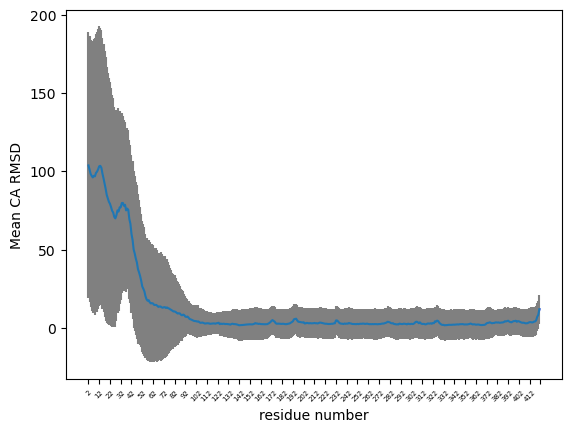

In [31]:
plt.plot(resids, ca_rmsd_avg, 'b-')
plt.errorbar(resids, ca_rmsd_avg, ca_rmsd_std, ecolor='gray')
plt.xlabel('residue number')
plt.xticks(rotation=45)
plt.xticks(np.arange(0, len(resids)+1, 10))
plt.xticks(fontsize=5)
plt.ylabel('Mean CA RMSD')
# plt.legend(['traj2-CA-rmsd', 'traj2-BB-rmsd'])
plt.savefig(str(out_dir / 'traj2_mean_ca_rmsd.png'))
plt.show()

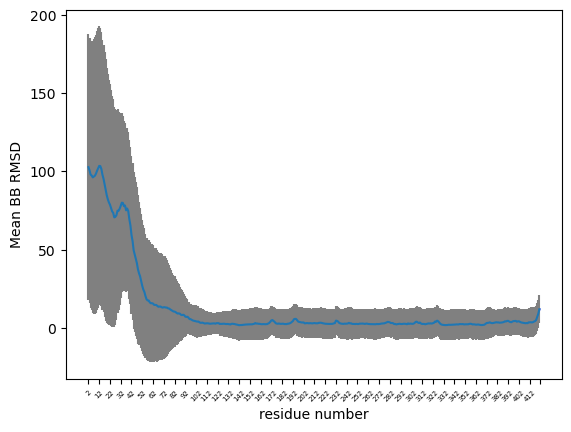

In [32]:
plt.plot(resids, bb_rmsd_avg, 'b-')
plt.errorbar(resids, bb_rmsd_avg, bb_rmsd_std, ecolor='gray')
plt.xlabel('residue number')
plt.xticks(rotation=45)
plt.xticks(np.arange(0, len(resids)+1, 10))
plt.xticks(fontsize=5)
plt.ylabel('Mean BB RMSD')
# plt.legend(['traj2-CA-rmsd', 'traj2-BB-rmsd'])
plt.savefig(str(out_dir / 'traj2_mean_bb_rmsd.png'))
plt.show()

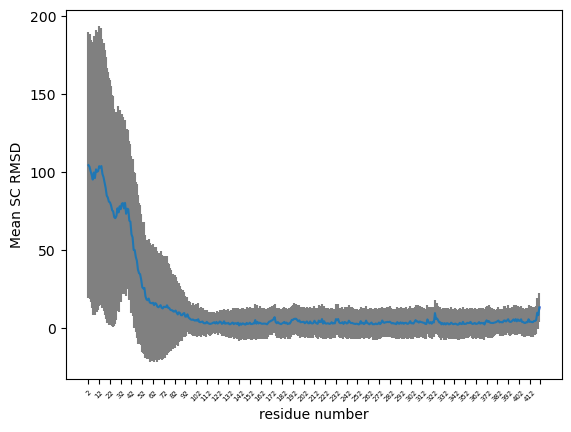

In [33]:
plt.plot(resids, sc_rmsd_avg, 'b-')
plt.errorbar(resids, sc_rmsd_avg, sc_rmsd_std, ecolor='gray')
plt.xlabel('residue number')
plt.xticks(rotation=45)
plt.xticks(np.arange(0, len(resids)+1, 10))
plt.xticks(fontsize=5)
plt.ylabel('Mean SC RMSD')
# plt.legend(['traj2-CA-rmsd', 'traj2-BB-rmsd'])
plt.savefig(str(out_dir / 'traj2_mean_sc_rmsd.png'))
plt.show()

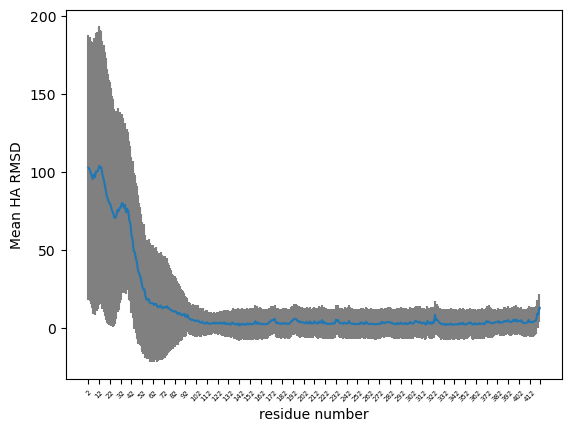

In [34]:
plt.plot(resids, ha_rmsd_avg, 'b-')
plt.errorbar(resids, ha_rmsd_avg, ha_rmsd_std, ecolor='gray')
plt.xlabel('residue number')
plt.xticks(rotation=45)
plt.xticks(np.arange(0, len(resids)+1, 10))
plt.xticks(fontsize=5)
plt.ylabel('Mean HA RMSD')
# plt.legend(['traj2-CA-rmsd', 'traj2-BB-rmsd'])
plt.savefig(str(out_dir / 'traj2_mean_ha_rmsd.png'))
plt.show()

## 5. Dihedral, by residue, analyses

In [48]:
##don't need to do the same steps as 4.1 again
#traj1
byres_df3 = pd.DataFrame()
time = []
resid = []
resname = []
system = []
bb_dih = [] #backbone
sc_dih = [] #sidechain
#########################Added 07/13###############################
bb_dih_avg = []
bb_dih_std = []
bb_dih_std1 = []
bb_dih_std2 = []
sc_dih_avg = []
sc_dih_std = []
sc_dih_std1 = []
sc_dih_std2 = []
#########################Added 07/13###############################
##need to define what the fourth atom here in a sc dihedral is
#         #R, F, L, K, N, Q, W, E, D, H, Y
#         atom='CG'
#         #V, I
#         atom='CG1'
#         #T
#         atom='OG1'
#         #S
#         atom='OG'
#         #C
#         atom='SG'
#         #M
#         atom='SD'
#         #A
#         atom='HB1'
res_CG = ['ARG','PHE','LEU','LYS','ASN','GLN','TRP','GLU','ASP','HIS','HIE','HID','HIP','TYR']
res_CG1 = ['VAL','ILE']
res_OG1 = ['THR']
res_OG = ['SER']
res_SG = ['CYS']
res_SD = ['MET']
res_HB1 = ['ALA']
for k,res in enumerate(resids):
    #order matters here
    bb = pt.dihedral(traj1, f':{res}&@N :{res}&@CA :{res}&@C :{res}&!:HOH,WAT&@O')
    if resnames[k] == 'GLY' or resnames[k] == 'PRO':
        sc = []
        for j,dih in enumerate(bb):
            sc.append(0)
    else:
        if resnames[k] in res_CG:
            atom = 'CG'
        elif resnames[k] in res_CG1:
            atom = 'CG1'
        elif resnames[k] in res_OG1:
            atom = 'OG1'
        elif resnames[k] in res_OG:
            atom = 'OG'
        elif resnames[k] in res_SG:
            atom = 'SG'
        elif resnames[k] in res_SD:
            atom = 'SD'
        elif resnames[k] in res_HB1:
            atom = 'HB1'
        sc = pt.dihedral(traj1, f':{res}&@N :{res}&@CA :{res}&@CB :{res}&@{atom}')
    for j,dih in enumerate(bb):
        time.append(j*traj1_timestep)
        resid.append(res)
        resname.append(resnames[k])
        system.append('traj1')
        bb_dih.append(dih)
        sc_dih.append(sc[j])
    ##added 07/13
    bb_avg = np.mean(bb)
    bb_std = np.std(bb)
    bb_std1 = np.std(bb[:int((len(bb)/2))])
    bb_std2 = np.std(bb[int((len(bb)/2)):])
    sc_avg = np.mean(sc)
    sc_std = np.std(sc)
    sc_std1 = np.std(sc[:int((len(sc)/2))])
    sc_std2 = np.std(sc[int((len(sc)/2)):])
    bb_dih_avg.append(bb_avg)
    bb_dih_std.append(bb_std)
    bb_dih_std1.append(bb_std1)
    bb_dih_std2.append(bb_std2)
    sc_dih_avg.append(sc_avg)
    sc_dih_std.append(sc_std)
    sc_dih_std1.append(sc_std1)
    sc_dih_std2.append(sc_std2)
byres_df3['time'] = time
byres_df3['resid'] = resid
byres_df3['resname'] = resname
byres_df3['BB DIH'] = bb_dih
byres_df3['SC DIH'] = sc_dih
byres_df3.to_csv(str(out_dir / 'traj1_dih_byres.csv'), index=False)
byres_df3

,time,resid,resname,BB DIH,SC DIH
0,0,2,GLY,4.018680,0.000000
1,20,2,GLY,-11.891834,0.000000
2,40,2,GLY,-13.141856,0.000000
3,60,2,GLY,20.852690,0.000000
4,80,2,GLY,8.312519,0.000000
...,...,...,...,...,...
419995,19900,421,TRP,-3.883358,-48.565864
419996,19920,421,TRP,-29.303413,-45.434604
419997,19940,421,TRP,-11.516743,-53.397963
419998,19960,421,TRP,2.060702,-57.282393


In [49]:
byres_stats3 = pd.DataFrame()
byres_stats3['resid'] = resids
byres_stats3['resname'] = resnames
byres_stats3['mean bb dih'] = bb_dih_avg
byres_stats3['std bb dih'] = bb_dih_std
byres_stats3['std1 bb dih'] = bb_dih_std1
byres_stats3['std2 bb dih'] = bb_dih_std2
byres_stats3['mean sc dih'] = sc_dih_avg
byres_stats3['std sc dih'] = sc_dih_std
byres_stats3['std1 sc dih'] = sc_dih_std1
byres_stats3['std2 sc dih'] = sc_dih_std2
byres_stats3.to_csv(str(out_dir / 'traj1_byres_dihedral_stats.csv'), index=False)
byres_stats3

,resid,resname,mean bb dih,std bb dih,std1 bb dih,std2 bb dih,mean sc dih,std sc dih,std1 sc dih,std2 sc dih
0,2,GLY,-1.969303,9.774360,9.976041,9.567326,0.000000,0.000000,0.000000,0.000000
1,3,PRO,148.174971,58.074688,63.394279,52.191472,0.000000,0.000000,0.000000,0.000000
2,4,ARG,143.528029,18.446642,23.415459,11.495236,-60.795850,37.959662,25.469853,46.726907
3,5,PHE,-58.572793,9.180680,9.049738,9.309677,-49.628291,8.188558,7.307008,8.320745
4,6,LEU,-40.013340,12.102521,11.823724,12.374249,-62.307444,8.105793,7.961217,8.240882
...,...,...,...,...,...,...,...,...,...,...
415,417,ASN,125.368788,105.974352,108.209713,103.641425,-66.570645,48.213473,10.899516,67.237599
416,418,THR,149.990933,9.901388,9.849194,9.915927,62.038386,8.243681,8.139534,8.343054
417,419,HIE,-34.844675,9.862386,9.872509,9.851735,-20.378225,172.666118,170.974883,173.844883
418,420,VAL,-38.165839,10.184191,10.909870,9.145015,-53.930327,89.414993,102.180693,73.659523


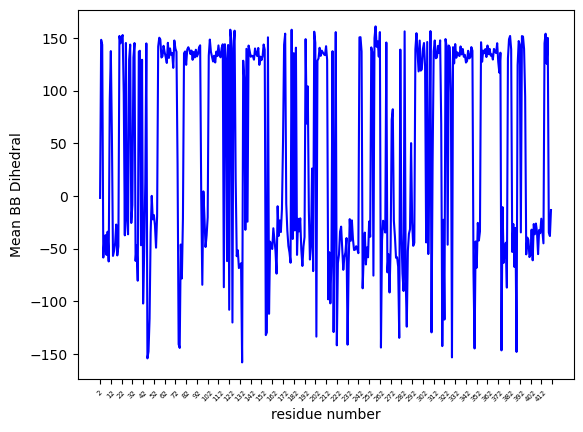

In [50]:
plt.plot(resids, bb_dih_avg, 'b-')
plt.xlabel('residue number')
plt.xticks(rotation=45)
plt.xticks(np.arange(0, len(resids)+1, 10))
plt.xticks(fontsize=5)
plt.ylabel('Mean BB Dihedral')
# plt.legend(['traj2-CA-rmsd', 'traj2-BB-rmsd'])
plt.savefig(str(out_dir / 'traj1_mean_bb_dihedral.png'))
plt.show()

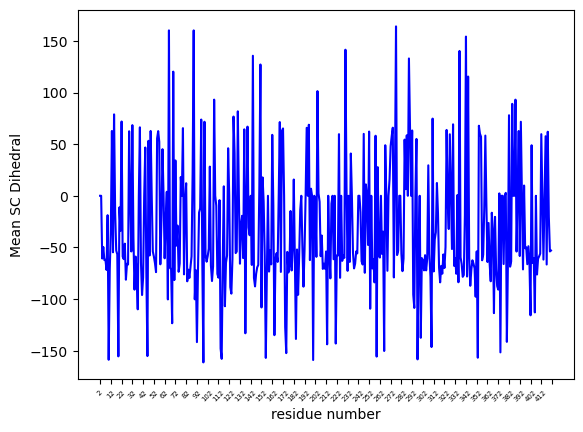

In [51]:
plt.plot(resids, sc_dih_avg, 'b-')
plt.xlabel('residue number')
plt.xticks(rotation=45)
plt.xticks(np.arange(0, len(resids)+1, 10))
plt.xticks(fontsize=5)
plt.ylabel('Mean SC Dihedral')
# plt.legend(['traj2-CA-rmsd', 'traj2-BB-rmsd'])
plt.savefig(str(out_dir / 'traj1_mean_sc_dihedral.png'))
plt.show()

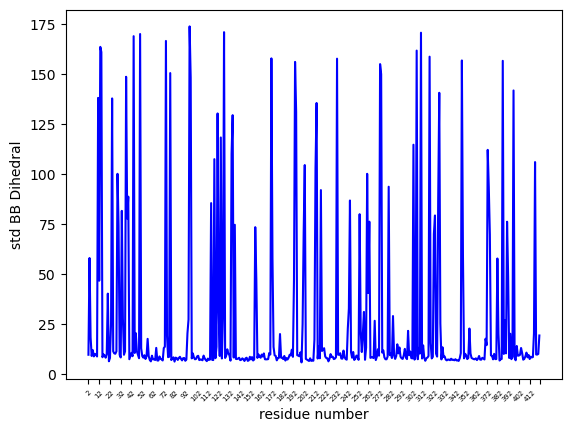

In [39]:
plt.plot(resids, bb_dih_std, 'b-')
plt.xlabel('residue number')
plt.xticks(rotation=45)
plt.xticks(np.arange(0, len(resids)+1, 10))
plt.xticks(fontsize=5)
plt.ylabel('std BB Dihedral')
# plt.legend(['traj2-CA-rmsd', 'traj2-BB-rmsd'])
plt.savefig(str(out_dir / 'traj1_std_bb_dihedral.png'))
plt.show()

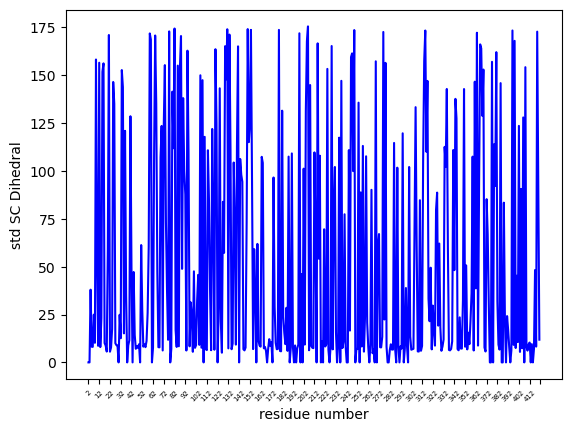

In [40]:
plt.plot(resids, sc_dih_std, 'b-')
plt.xlabel('residue number')
plt.xticks(rotation=45)
plt.xticks(np.arange(0, len(resids)+1, 10))
plt.xticks(fontsize=5)
plt.ylabel('std SC Dihedral')
# plt.legend(['traj2-CA-rmsd', 'traj2-BB-rmsd'])
plt.savefig(str(out_dir / 'traj1_std_sc_dihedral.png'))
plt.show()

In [41]:
##don't need to do the same steps as 4.1 again
#traj1
byres_df4 = pd.DataFrame()
time = []
resid = []
resname = []
system = []
bb_dih = [] #backbone
sc_dih = [] #sidechain
#########################Added 07/13###############################
bb_dih_avg = []
bb_dih_std = []
bb_dih_std1 = []
bb_dih_std2 = []
sc_dih_avg = []
sc_dih_std = []
sc_dih_std1 = []
sc_dih_std2 = []
#########################Added 07/13###############################
##need to define what the fourth atom here in a sc dihedral is
#         #R, F, L, K, N, Q, W, E, D, H, Y
#         atom='CG'
#         #V, I
#         atom='CG1'
#         #T
#         atom='OG1'
#         #S
#         atom='OG'
#         #C
#         atom='SG'
#         #M
#         atom='SD'
#         #A
#         atom='HB1'
res_CG = ['ARG','PHE','LEU','LYS','ASN','GLN','TRP','GLU','ASP','HIS','HIE','HID','HIP','TYR']
res_CG1 = ['VAL','ILE']
res_OG1 = ['THR']
res_OG = ['SER']
res_SG = ['CYS']
res_SD = ['MET']
res_HB1 = ['ALA']
for k,res in enumerate(resids):
    #order matters here
    bb = pt.dihedral(traj2, f':{res}&@N :{res}&@CA :{res}&@C :{res}&!:HOH,WAT&@O')
    if resnames[k] == 'GLY' or resnames[k] == 'PRO':
        sc = []
        for j,dih in enumerate(bb):
            sc.append(0)
    else:
        if resnames[k] in res_CG:
            atom = 'CG'
        elif resnames[k] in res_CG1:
            atom = 'CG1'
        elif resnames[k] in res_OG1:
            atom = 'OG1'
        elif resnames[k] in res_OG:
            atom = 'OG'
        elif resnames[k] in res_SG:
            atom = 'SG'
        elif resnames[k] in res_SD:
            atom = 'SD'
        elif resnames[k] in res_HB1:
            atom = 'HB1'
        sc = pt.dihedral(traj2, f':{res}&@N :{res}&@CA :{res}&@CB :{res}&@{atom}')
    for j,dih in enumerate(bb):
        time.append(j*traj2_timestep)
        resid.append(res)
        resname.append(resnames[k])
        system.append('traj1')
        bb_dih.append(dih)
        sc_dih.append(sc[j])
    ##added 07/13
    bb_avg = np.mean(bb)
    bb_std = np.std(bb)
    bb_std1 = np.std(bb[:int((len(bb)/2))])
    bb_std2 = np.std(bb[int((len(bb)/2)):])
    sc_avg = np.mean(sc)
    sc_std = np.std(sc)
    sc_std1 = np.std(sc[:int((len(sc)/2))])
    sc_std2 = np.std(sc[int((len(sc)/2)):])
    bb_dih_avg.append(bb_avg)
    bb_dih_std.append(bb_std)
    bb_dih_std1.append(bb_std1)
    bb_dih_std2.append(bb_std2)
    sc_dih_avg.append(sc_avg)
    sc_dih_std.append(sc_std)
    sc_dih_std1.append(sc_std1)
    sc_dih_std2.append(sc_std2)
byres_df4['time'] = time
byres_df4['resid'] = resid
byres_df4['resname'] = resname
byres_df4['BB DIH'] = bb_dih
byres_df4['SC DIH'] = sc_dih
byres_df4.to_csv(str(out_dir / 'traj2_dih_byres.csv'), index=False)
byres_df4

,time,resid,resname,BB DIH,SC DIH
0,0,2,GLY,-9.499438,0.000000
1,100,2,GLY,-20.452225,0.000000
2,200,2,GLY,-5.595701,0.000000
3,300,2,GLY,-12.821604,0.000000
4,400,2,GLY,-8.787667,0.000000
...,...,...,...,...,...
419995,99500,421,TRP,112.645497,-48.108464
419996,99600,421,TRP,-40.376857,64.308232
419997,99700,421,TRP,-32.213600,57.955132
419998,99800,421,TRP,146.712331,-159.222444


In [42]:
byres_stats4 = pd.DataFrame()
byres_stats4['resid'] = resids
byres_stats4['resname'] = resnames
byres_stats4['mean bb dih'] = bb_dih_avg
byres_stats4['std bb dih'] = bb_dih_std
byres_stats4['std1 bb dih'] = bb_dih_std1
byres_stats4['std2 bb dih'] = bb_dih_std2
byres_stats4['mean sc dih'] = sc_dih_avg
byres_stats4['std sc dih'] = sc_dih_std
byres_stats4['std1 sc dih'] = sc_dih_std1
byres_stats4['std2 sc dih'] = sc_dih_std2
byres_stats4.to_csv(str(out_dir / 'traj2_byres_dihedral_stats.csv'), index=False)
byres_stats4

,resid,resname,mean bb dih,std bb dih,std1 bb dih,std2 bb dih,mean sc dih,std sc dih,std1 sc dih,std2 sc dih
0,2,GLY,2.671211,33.568205,28.976007,37.527382,0.000000,0.000000,0.000000,0.000000
1,3,PRO,-7.859311,80.430474,57.245830,96.207237,0.000000,0.000000,0.000000,0.000000
2,4,ARG,-4.991484,124.303939,139.164871,105.792767,-46.608107,84.945619,61.762191,101.591200
3,5,PHE,-40.540838,87.731861,76.246102,89.533075,-24.235430,116.457892,104.885257,126.735933
4,6,LEU,-35.214485,56.773558,18.688520,77.831812,-52.590769,75.431139,65.422232,84.246936
...,...,...,...,...,...,...,...,...,...,...
415,417,ASN,53.371006,141.485210,140.678968,141.019743,-70.038751,91.192843,91.727332,90.643102
416,418,THR,8.384869,94.378386,90.485935,98.047616,-30.819329,95.338539,106.464995,82.517566
417,419,HIE,-21.516749,59.669643,21.251016,80.922497,-40.522996,141.213450,156.189873,123.911666
418,420,VAL,-17.044709,94.288867,86.996079,100.537984,-12.467681,120.072756,116.022375,122.128005


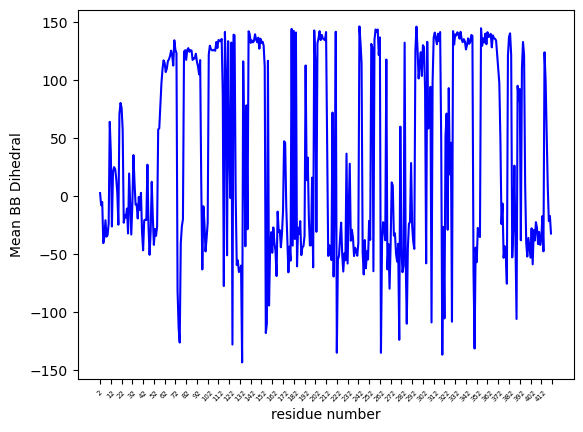

In [43]:
plt.plot(resids, bb_dih_avg, 'b-')
plt.xlabel('residue number')
plt.xticks(rotation=45)
plt.xticks(np.arange(0, len(resids)+1, 10))
plt.xticks(fontsize=5)
plt.ylabel('Mean BB Dihedral')
# plt.legend(['traj2-CA-rmsd', 'traj2-BB-rmsd'])
plt.savefig(str(out_dir / 'traj2_mean_bb_dihedral.png'))
plt.show()

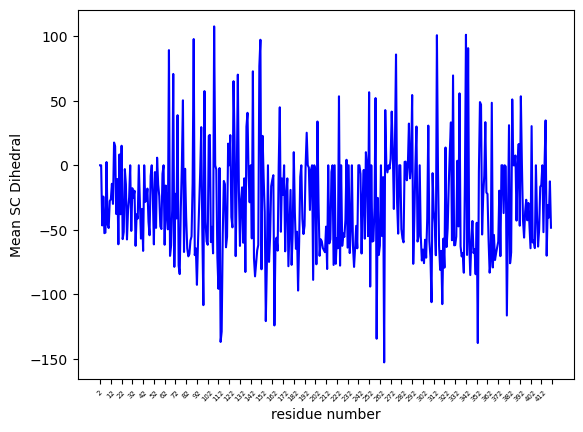

In [44]:
plt.plot(resids, sc_dih_avg, 'b-')
plt.xlabel('residue number')
plt.xticks(rotation=45)
plt.xticks(np.arange(0, len(resids)+1, 10))
plt.xticks(fontsize=5)
plt.ylabel('Mean SC Dihedral')
# plt.legend(['traj2-CA-rmsd', 'traj2-BB-rmsd'])
plt.savefig(str(out_dir / 'traj2_mean_sc_dihedral.png'))
plt.show()

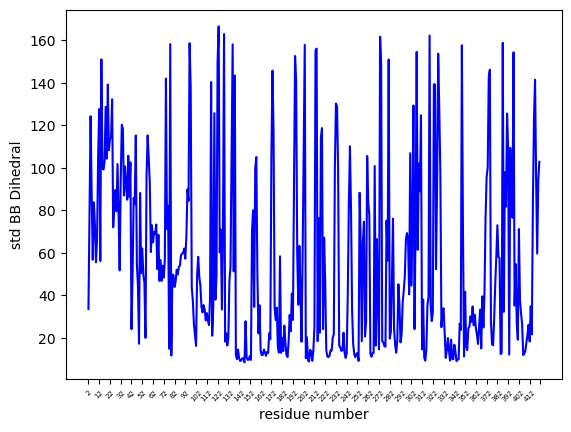

In [45]:
plt.plot(resids, bb_dih_std, 'b-')
plt.xlabel('residue number')
plt.xticks(rotation=45)
plt.xticks(np.arange(0, len(resids)+1, 10))
plt.xticks(fontsize=5)
plt.ylabel('std BB Dihedral')
# plt.legend(['traj2-CA-rmsd', 'traj2-BB-rmsd'])
plt.savefig(str(out_dir / 'traj2_std_bb_dihedral.png'))
plt.show()

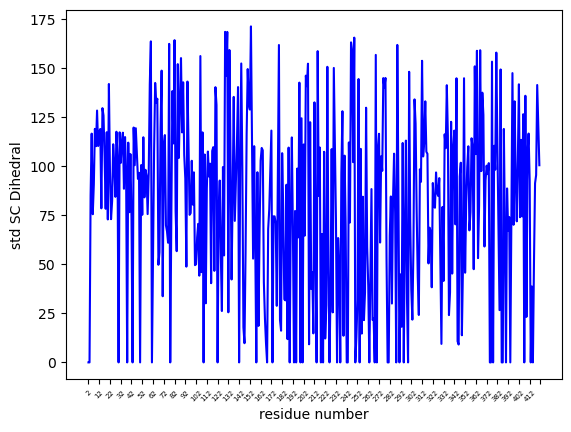

In [46]:
plt.plot(resids, sc_dih_std, 'b-')
plt.xlabel('residue number')
plt.xticks(rotation=45)
plt.xticks(np.arange(0, len(resids)+1, 10))
plt.xticks(fontsize=5)
plt.ylabel('std SC Dihedral')
# plt.legend(['traj2-CA-rmsd', 'traj2-BB-rmsd'])
plt.savefig(str(out_dir / 'traj2_std_sc_dihedral.png'))
plt.show()

In [47]:
## stats.entropy

## 6. Ligand analysis